<a href="https://colab.research.google.com/github/CarlosRochaCx/MNA/blob/main/MNA_IAyAA_Actividad_curvas_ROC_y_PR_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
**Actividad Curvas ROC y PR**


# **Itroducción**

La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

El archivo de los datos está en Canvas y se llama "oil-spill.csv".


En la siguiente liga se encuentra la liga del artículo relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico. La última columna es de valor 1 (hay derrame en esa sección de la imagen) o 0 (no hay derrame en esa sección de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

En la siguiente liga puedes encontrar información de varias de las métricas que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La media geométrica se puede obtener combinando las métricas anteriores, pero para fines prácticos usaremos la de la librería llamada "imbalanced-learn":

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [129]:
# Incluye todas las librerías que consideres adecuadas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    make_scorer, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from imblearn.metrics import geometric_mean_score


Para fines de la actividad procesaremos los datos de manera estándar para concentrarnos en los temas de la actividad.

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
path = '/content/drive/MyDrive/Colab Notebooks/MNA - Maestría en Inteligencia Artificial Aplicada/Inteligencia Artificial y Aprendizaje Automático/Tareas/Actividad Semana 4/oil_spill.csv'
df = read_csv(path, header=None)   # no tienen nombre las columnas

print('Timensión del DataFrame',df.shape)

# eliminamos las siguientes columnas:
df.drop(22, axis=1, inplace=True)    # Esta columna tiene un solo valor constante.
df.drop(0, axis=1, inplace=True)     # Esta columna contiene información de secciones (batches) de las imágenes, que no la requerimos.

df.columns = [i for i in range(df.shape[1])]   # Renombramos las columnas para que sean enteros consecutivos.

# Particionamos los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)
print('\nPartición:')
print('Train: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))

Timensión del DataFrame (937, 50)

Partición:
Train: Conteo clase positiva=29, Porcentaje=4.40%
Val: Conteo clase positiva=7, Porcentaje=4.24%
Test: Conteo clase positiva=5, Porcentaje=4.42%


Breve descripción numérica y gráfica del conjunto de entrenamiento:

In [132]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


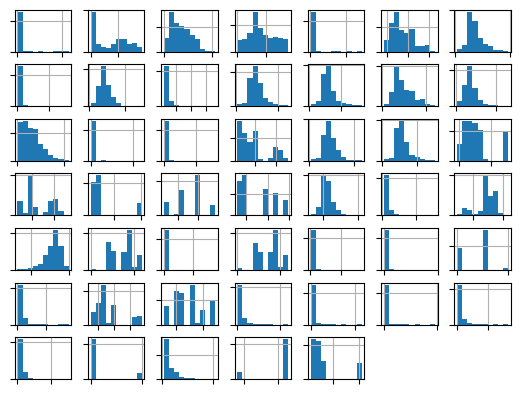

In [133]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()

In [134]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

In [135]:
# Código-1:
# Aplicamos la función Dummy:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, modeloD)

print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (mean(scores), std(scores)))

Métrica G-mean - Media Geométrica: 0.426 (0.166)


# **Ejercicio-1**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como lo que significa el valor que se obtiene en su salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



1.   ```def evaluate_model(X, y, model):```

    El código inicia definiendo una función llamada ```evaluate_model```, la cuál recibirá tres argumentos: Una variable ```X```, una variable objetivo ```y``` y un modelo a evaluar ```model```.

2.   ```cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)```

    Posteriormente se configura la estrategia de validación cruzada a través de ```RepeatedStratifiedKFold```, estableciendo que esta seguirá 10 particiones y se repetirá 3 veces. De igual forma se agrega el parámetro ```random_state=1``` para que los resultados sean repoducibles.

3.   ```metric = make_scorer(geometric_mean_score)```

    La tercera línea de código define la métrica de evaluación a través de ```make_scorer```, usando la media geométrica (G-mean), la cuál es de gran utilidad para evaluar el rendimiento cuando se trabaja con conjuntos de datos desbalanceados.

4.   ```scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)```

    En esta línea se calcula la métrica G-mean y se aplica la validación cruzada con el modelo recibido el cuál es calculado para cada iteración. ```n_jobs=-1``` asegura que se usen todos los núcleos disponibles para que el proceso sea más ágil.  

5.   ```return scores```

    Este código devuelve todos los resultados obtenidos para cada iteración de la validación cruzada.


6.   ```modeloD = DummyClassifier(strategy='uniform')```

    Aquí se crea un modelo DummyClassifier, el cual genera predicciones aleatorias, y se indica que estas sean distribuidas uniformemente, con la finalidad de ser una referencia para comparar otros modelos.

7.   ```scores = evaluate_model(X, y, modeloD)```

    Esta línea llama a la función ```evaluate_model``` previamente definido y pasa los argumentos requeridos. La finalidad de esta línea es realizar la validación cruzada, evaluando el modelo y utilizando G-mean como la métrica.

8.   ```print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (mean(scores), std(scores)))```

    Finalmente, el código imprime la media y la desviación estándar de los puntajes recibidos, resumiendo el rendimiento del modelo en cuanto a su nivel de rendimiento medio y a su variabilidad.

9.   Significado del valor de salida:

    El valor que se imprime al final es el promedio de los resultados de cada iteración de validación cruzada, así como su desviación estándar. Este valor mide qué tan equilibrado y robusto es el modelo evaluado en la clasificación de clases desbalanceadas, dando un resultado  
    
    En este caso, un valor de 0.433 como media de G-mean es un valor bajo, indicando que el modelo tiene dificultades para clasificar correctamente las clases, y al tener una desviación estándar de 0.201 se indica que el rendimiento del modelo es inestable.

**+++++++++++ Termina sección para agregar texto ++++++++++++++**

Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos:

In [136]:
# Transforamaciones numéricas:

numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('std_transformer', StandardScaler())])
numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [137]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.951 (0.015)
G-mean: >> 0.753 (0.079)

LASSO
Exactitud: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Exactitud: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Exactitud: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



<ipython-input-138-0db74e03d2d4>:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados1, labels=nombres,  showmeans=True)


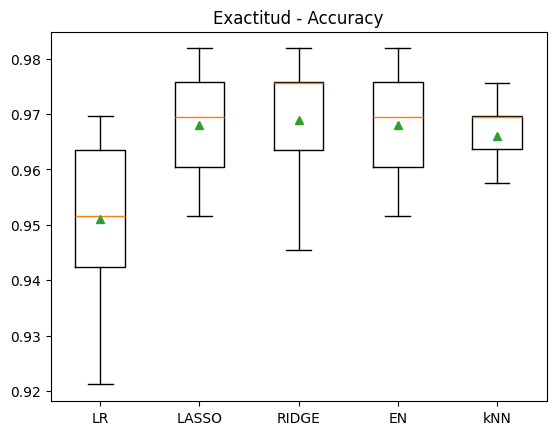

<ipython-input-138-0db74e03d2d4>:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados2, labels=nombres,  showmeans=True)


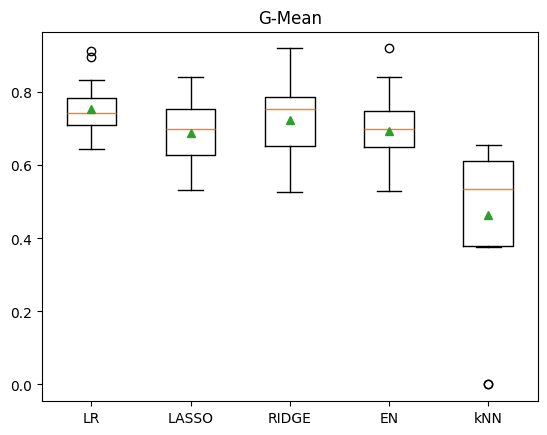

In [138]:
# Código-2:
# ACCURACY & G-mean

def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-2**

### **Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

La media geométrica de sensibilidad y especificidad (G-mean) es de gran relevancia en este problema debido al desbalance que presentan nuestros datos. La métrica de exactitud (Accuracy) mide el porcentaje total de predicciones correctas, pero no hace distinción entre las clases. Debido a esto, en casos como este en donde hay una clase mayoritaria, un modelo que siempre prediga dicha clase mayoritaria, podría tener una alta exactitud, aún y cuando su desempeño en la clase minoritaria sea mala.

Esto lo podemos ver tanto en las métricas de salida como en la gráfica de boxplots. En los resultados y gráfica de exactitud, podemos observar que todos nuestros modelos arrojan una exactitud superior a .95, por lo que podría aparentar que todos nuestos modelos son buenos. Sin embargo, esto cambia al aplicar la métrica de G-mean.

Gracias a que G-mean penaliza fuertemente el bajo desempeño en cualquier clase, es una métrica de gran utilidad para problemas desbalanceados. Un claro ejemplo es kNN, la cual mientras su nivel de exactitud era de .966, su G-mean es bastante baja, tan solo siendo de .464 y con una gran variabilidad de .204, por lo que indica que este modelo no maneja correctamente las clases minoritarias.

Los gráficos ayudan a reforzar esto, ya que en el gráfico de G-mean podemos ver claramente que kNN es el peor modelo, con la menor mediana y con outliers a niveles muy bajos. Por lo tanto, los gráficos respaldan la decisión de usar G-mean como métrica en lugar de la exactitud.


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-3**

### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una función llamada "mis_modelos2()" y utilízala para definir los mismos modelos de regresión logística, pero incluyendo el argumento class_weight='balanced'. Los demás hiperparámetros los puedes variar si así lo consideras adecuado. Incluye kNN, aunque no tiene argumento para balanceo de las clases de salida.**

Resultados de Validación - Modelos Balanceados:
LR-Balanced
Exactitud: >> 0.951 (0.016)
G-mean: >> 0.692 (0.117)

LASSO-Balanced
Exactitud: >> 0.930 (0.023)
G-mean: >> 0.849 (0.069)

RIDGE-Balanced
Exactitud: >> 0.933 (0.022)
G-mean: >> 0.852 (0.070)

EN-Balanced
Exactitud: >> 0.931 (0.021)
G-mean: >> 0.851 (0.070)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



<ipython-input-139-d67bc72361e6>:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados2, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.


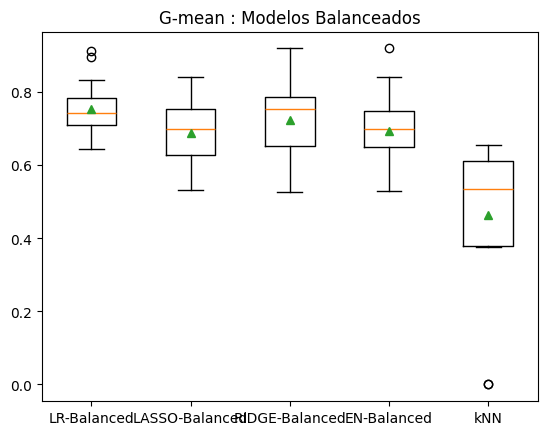

In [139]:
#  Casos balancedos con hiperparámetro de Regresión Logística:

# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos2():
    modelos, nombres = list(), list()

    modelos.append(LogisticRegression(penalty=None,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LR-Balanced')

    modelos.append(LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LASSO-Balanced')

    modelos.append(LogisticRegression(penalty='l2',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('RIDGE-Balanced')

    modelos.append(LogisticRegression(penalty='elasticnet',
                                      l1_ratio=0.5,
                                      solver='saga',
                                      class_weight='balanced',
                                      max_iter=5000,
                                      random_state=1))
    nombres.append('EN-Balanced')

    modelos.append(KNeighborsClassifier(n_neighbors=5))
    nombres.append('kNN')

    return modelos, nombres

modelos2, nombres2 = mis_modelos2()

resultados1_bal, resultados2_bal = list(), list()
print('Resultados de Validación - Modelos Balanceados:')

for i in range(len(modelos2)):

  pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos2[i])])
  cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud': 'accuracy', 'm_geo': mi_metrica},
                          cv=cv2)

  resultados1_bal.append(scores['test_exactitud'])
  resultados2_bal.append(scores['test_m_geo'])

  print(nombres2[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++

plt.boxplot(resultados2, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.
plt.title("G-mean : Modelos Balanceados")
plt.show()

# **Ejercicio-4**

### **4a) Selecciona el que consideres sea el mejor modelo encontrado hasta ahora y utilízalo para obtener los gráficos curva-ROC y curva-PR, así como los valores de sus áreas bajo la curva. Sigue utilizando los conjuntos de entrenamiento y validación.**



<Figure size 600x600 with 0 Axes>

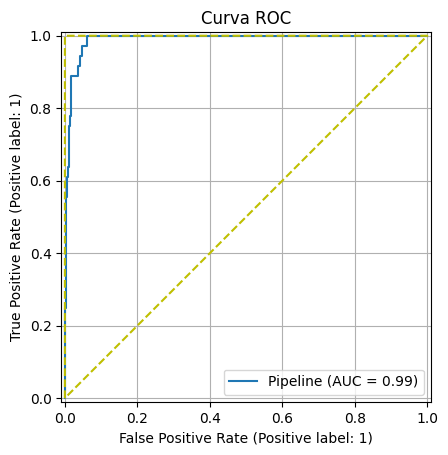

<Figure size 600x600 with 0 Axes>

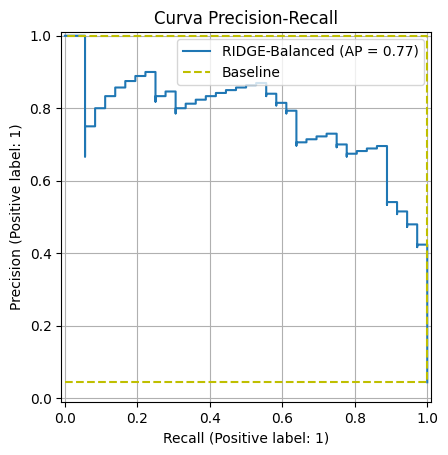

In [140]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

#Seleccionamos RIDGE como el mejor modelo

mejor_modelo = LogisticRegression(penalty='l2',
                                  max_iter=2000,
                                  class_weight='balanced',
                                  random_state=1)

pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', mejor_modelo)])
pipeline.fit(Xtv, np.ravel(ytv))

# Curva ROC

plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(pipeline, Xtv, ytv)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.title('Curva ROC')
plt.grid()
plt.show()

# Curva PR

plt.figure(figsize=(6, 6))
PrecisionRecallDisplay.from_estimator(pipeline, Xtv, ytv, name="RIDGE-Balanced")

tasa_positiva = ytv.mean()
plt.plot([0, 1, 1, 0], [tasa_positiva, tasa_positiva, 1, 1], 'y--', label="Baseline")
plt.legend(loc="upper right")

plt.title('Curva Precision-Recall')
plt.grid()
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

### **4b) Incluye tus conclusiones de los gráficos obtenidos en el inciso anterior.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

El modelo seleccionado muestra tener un buen desempeño en ambas gráficas, tanto en la curva ROC como en la curva de Precision-Recall.

Por parte de la Curva ROC, el model arroja un AUC de 0.99, un valor muy cercano a 1, por lo que indica una capacidad favorable para la clasificación.

Por otro lado, la Curve Precision-Recall arroja un resultado de 0.77, considerablemente buena si tomamos en cuenta la alta desproporción de clases que tienen los datos.

**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido.**

<Figure size 600x600 with 0 Axes>

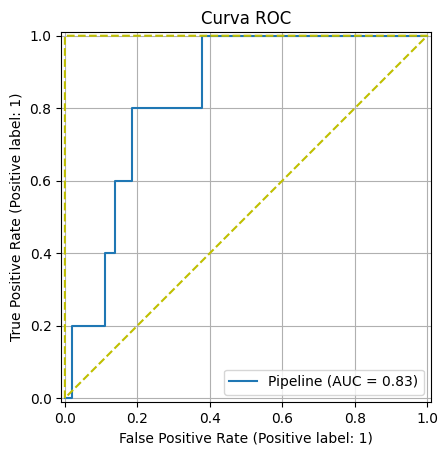

<Figure size 600x600 with 0 Axes>

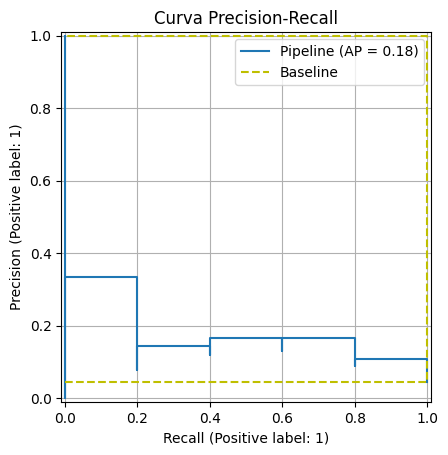

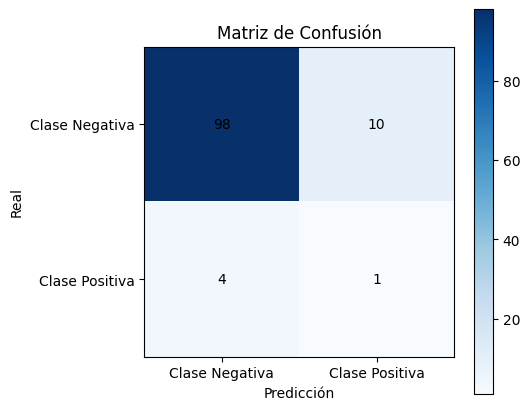

In [141]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

pipeline.fit(Xtrain, np.ravel(ytrain))

ytest_pred = pipeline.predict(Xtest)
ytest_pred_proba = pipeline.predict_proba(Xtest)[:, 1]

# Curva ROC

plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(pipeline, Xtest, ytest)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

# Curva PR

plt.figure(figsize=(6, 6))
PrecisionRecallDisplay.from_estimator(pipeline, Xtest, ytest)
tasa_positiva = ytv.mean()
plt.plot([0, 1, 1, 0], [tasa_positiva, tasa_positiva, 1, 1], 'y--', label="Baseline")
plt.legend(loc="upper right")
plt.title('Curva Precision-Recall')
plt.grid()
plt.show()

# Matriz de Confusión

conf_matrix = confusion_matrix(ytest, ytest_pred)

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], labels=['Clase Negativa', 'Clase Positiva'])
plt.yticks([0, 1], labels=['Clase Negativa', 'Clase Positiva'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()
# **+++++++++++ Termina sección para agregar código ++++++++++++++

# **Ejercicio-6**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

En general, esta actividad me permitió entender la importancia de considerar el desbalance de clases en problemas de aprendizaje automático, y sobre todo a saber utilizar otras métricas - como el G-mean - al analizar el desempeño de un modelo con respecto a un conjunto de datos.

De igual forma resalto la importancia de acompañar los análisis realizados con gráficos que permitan visualizar facilmente los posibles retos que podrían tener los modelos analizados, así como incorporar otros aprendizajes que hemos anlizado en actividades anteriores, tal como la matriz de confusión.

Tomando en cuenta los resultados de esta actividad, podemos ver claramente como todo esto es de suma importancia. A pesar de que la área bajo la curva ROC dió un valor final de 0.83, que podría considerarse bueno, el área bajo la curva Precision-Recall solo fue de 0.18, por lo que el modelo tiene dificultades para identificar la clase positiva. Esto es respaldado al observar la matriz de confusión, en donde el modelo solamente identificó correctamente 1 de los 5 casos positivos.

**+++++++++++ Termina sección para agregar texto ++++++++++++++**

## **<<< Fin de la Actividad de la Semana - curvas ROC y PR >>>**